### load libraries

In [63]:
import os, glob
from os.path import join
from scipy.stats import zscore
from scipy.stats import pearsonr

# import mvpa2 as mv
# from mvpa2.base.hdf5 import h5load
# from mvpa2.datasets.gifti import aa_dataset
import sys
import nibabel as nib
import numpy as np
from matplotlib import colors

* anatomical, 
* hyperalinment_common (makes most sense for ISC)

In [2]:
def read_gifti(gifti_fn):
    gii = nib.load(gifti_fn)
    data = np.vstack([da.data[np.newaxis, :]
                      for da in gii.darrays])
    return data

In [27]:
def write_gifti(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    nib.gifti.giftiio.write(gii, output_fn)

In [3]:
def write_gifti(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    if data.ndim == 1:
        data = data[np.newaxis, :]
    for row in data:
        gda = nib.gifti.GiftiDataArray(row)
        gii.add_gifti_data_array(gda)
    nib.gifti.giftiio.write(gii, output_fn)

### directories

In [4]:
# parameters
# gifti_dir = '/dartfs/rc/lab/D/DBIC/DBIC/life_data/life_dataset'
# gifti_dir = '/Volumes/rc/lab/D/DBIC/DBIC/life_data/life_dataset' # heejung local
data_dir = '/Volumes/life_data'
niml_dir = join(data_dir, 'niml')
gifti_dir = join(data_dir, 'life_dataset')
runs = [1, 2, 3, 4]
fmri_durs = {1: 374, 2: 346, 3: 377, 4: 412}
n_samples = 1509
n_vertices = 40962
n_medial = {'lh': 3486, 'rh': 3491}
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']

In [5]:
hemisphere = 'lh'
run = 1
# load HAcommon gifti files
# filename example: # sub-rid000041_task-life_acq-374vol_run-01_desc-HAcommon1.lh.gii
# gifti_list = glob.glob(os.path.join(gifti_dir, f'*_task-life_acq-*vol_run-01_desc-HAcommon1.lh.gii'))
per_run = []
# short_list= gifti_list[0:3]
# for gifti_fname in sorted(gifti_list):
for subject in subjects:
    gifti_fname = join(gifti_dir, f'{subject}_task-life_acq-{fmri_durs[run]}vol_run-0{run}_desc-HAcommon{run}.{hemisphere}.gii')
    print(gifti_fname)
    gifti_data = read_gifti(gifti_fname)
    per_run.append(gifti_data)
    print(f'individual gifti data shape: {gifti_data.shape}')
all_data = np.squeeze(np.array(per_run))
print(f'stacked data shape: {all_data.shape}')

/Volumes/life_data/life_dataset/sub-rid000001_task-life_acq-374vol_run-01_desc-HAcommon1.lh.gii
individual gifti data shape: (1, 374, 40962)
/Volumes/life_data/life_dataset/sub-rid000005_task-life_acq-374vol_run-01_desc-HAcommon1.lh.gii
individual gifti data shape: (1, 374, 40962)
/Volumes/life_data/life_dataset/sub-rid000006_task-life_acq-374vol_run-01_desc-HAcommon1.lh.gii
individual gifti data shape: (1, 374, 40962)
/Volumes/life_data/life_dataset/sub-rid000009_task-life_acq-374vol_run-01_desc-HAcommon1.lh.gii
individual gifti data shape: (1, 374, 40962)
/Volumes/life_data/life_dataset/sub-rid000012_task-life_acq-374vol_run-01_desc-HAcommon1.lh.gii
individual gifti data shape: (1, 374, 40962)
/Volumes/life_data/life_dataset/sub-rid000014_task-life_acq-374vol_run-01_desc-HAcommon1.lh.gii
individual gifti data shape: (1, 374, 40962)
/Volumes/life_data/life_dataset/sub-rid000017_task-life_acq-374vol_run-01_desc-HAcommon1.lh.gii
individual gifti data shape: (1, 374, 40962)
/Volumes/life

In [6]:
# as a manipulation check, see how many nans we have per giftifile
gifti_data
np.sum(np.all(np.isnan(np.squeeze(all_data[3])), axis=0))

897

In [7]:
# Create mask of cortical vertices excluding medial wall    
medial_mask = np.load(os.path.join(data_dir, 'niml',
                                   f'fsaverage6_medial_{hemisphere}.npy'))
assert np.sum(medial_mask) == n_medial[hemisphere]
cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
print(f"number of non-medial vertices: {len(cortical_coords)}")
print(f"all data shape (before removing medial): {all_data.shape}")
cortical_data = all_data[..., cortical_coords]
print(f"cortical data shape (after removing medial): {cortical_data.shape}")

number of non-medial vertices: 37476
all data shape (before removing medial): (18, 374, 40962)
cortical data shape (after removing medial): (18, 374, 37476)


In [8]:
isc_result = np.zeros((len(subjects), gifti_data.shape[-1]))
print(isc_result.shape)
# isc across time
subject_ids = range(len(subjects))

(18, 40962)


# 4/19/ w/ Sam

In [52]:
isc_result = np.zeros((len(subjects), gifti_data.shape[-1]))  # 
print(isc_result.shape)
# isc across time
subject_ids = np.arange(len(subjects))
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']
for subject_ind, subject in enumerate(subjects):
    target_subject = cortical_data[subject_ind, :, :]
    other_subjects = cortical_data[subject_ids != subject_ind, :, :] # TODO: print other_subjects is it (n-1)? is it excluding subject?
    other_avg = np.mean(other_subjects, axis=0)
    # other_subjects_concat = np.concatenate(other_subjects)
    result_gifti = np.zeros((1,40962))# original shape
    for i, voxel in enumerate(cortical_coords): # 1 2 7
        left_out_voxel = target_subject[:, i]# target_subject[:, voxel]
        other_avg_voxel = other_avg[:, i] # other_avg[:, voxel]
        isc = pearsonr(left_out_voxel, other_avg_voxel)[0]  # get r-value from pearsonr
        # if isc and cortical_data[-1] shape mattch
        result_gifti[0, voxel] = isc # cortical_coords and cortical_data need to have matching dimensions
        # isc_result[subject_ind, ]
        # TODO: extract subject ID
        # write_gifti
    np.save(file = f'/Volumes/life-encoding/scripts/sandbox_isc/subjectwise-ISC_{subject}_HAcommon_run1_lh.npy', arr = result_gifti) # save subject wise ISC
    suma_dir = '/Users/h/suma-fsaverage6'
    write_gifti(result_gifti.astype(float),
        template_fn = os.path.join(suma_dir, 'lh.pial.gii'), 
        output_fn = os.path.join(f'/Volumes/life-encoding/scripts/sandbox_isc/subjectwise-ISC_{subject}_HAcommon_run1_lh.gii'))
    # save result_gifti 
    isc_result[subject_ind] = result_gifti[0]
        # TODO: save to result_gifti
# write_gifti
np.save(file= '/Volumes/life-encoding/scripts/sandbox_isc/group_isc_result.npy', arr = isc_result)


(18, 40962)


/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_9153/3189128796.py:10: DeprecationWarning: giftiio.write function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  nib.gifti.giftiio.write(gii, output_fn)


In [10]:
isc_result.shape

(18, 40962)

In [16]:
# sanity check
other_subjects = cortical_data[subject_ids != subject, :, :]
other_subjects.shape

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_9153/208811771.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  other_subjects = cortical_data[subject_ids != subject, :, :]


(1, 18, 374, 37476)

In [17]:
# Custom mean estimator with Fisher z transformation for correlations
# code from Sam
def fisher_mean(correlation, axis=None):
    return np.tanh(np.nanmean(np.arctanh(correlation), axis=axis))

# group results

In [57]:
group_result =  np.load('/Volumes/life-encoding/scripts/sandbox_isc/group_isc_result.npy')
print(f"group isc shape before fisher mean: {group_result.shape}")
print(f"before fisher, min: {np.min(group_result)}, max: {np.max(group_result)}")
group_fisher = fisher_mean(group_result,axis = 0)
print(f"group isc shape after fisher mean: {group_fisher.shape}")
print(f"after fisher, min: {np.min(group_fisher)}, max: {np.max(group_fisher)}")


(40962,)


In [ ]:
#isc_fisher = fisher_mean(isc_result,axis = 0)
#print(isc_fisher.shape)

Notes: after getting the `isc_result` 
wrap it around with fisher_mean(isc_result)


# plot gifti

In [40]:
from nilearn.plotting import plot_surf
import matplotlib.pyplot as plt
suma_dir = '/Users/h/suma-fsaverage6'
fsaverage_gii_L = os.path.join(suma_dir, 'lh.pial.gii')
fsaverage_gii_R = os.path.join(suma_dir, 'rh.pial.gii')
fsaverage_inflated_L = os.path.join(suma_dir, 'lh.inflated.gii')
fsaverage_inflated_R = os.path.join(suma_dir, 'rh.inflated.gii')
isc_fisher_L = '/Volumes/life-encoding/scripts/sandbox_isc/isc_fisher_HAcommon_run1_lh.gii'
isc_sub01_L = '/Volumes/life-encoding/scripts/sandbox_isc/subjectwise-ISC_sub-rid000001_HAcommon_run1_lh.gii'
isc_sub05_L = '/Volumes/life-encoding/scripts/sandbox_isc/subjectwise-ISC_sub-rid000005_HAcommon_run1_lh.gii'
isc_sub06_L = '/Volumes/life-encoding/scripts/sandbox_isc/subjectwise-ISC_sub-rid000006_HAcommon_run1_lh.gii'
isc_sub09_L = '/Volumes/life-encoding/scripts/sandbox_isc/subjectwise-ISC_sub-rid000009_HAcommon_run1_lh.gii'

In [27]:
read_gifti(isc_fisher_L).shape

(1, 40962)

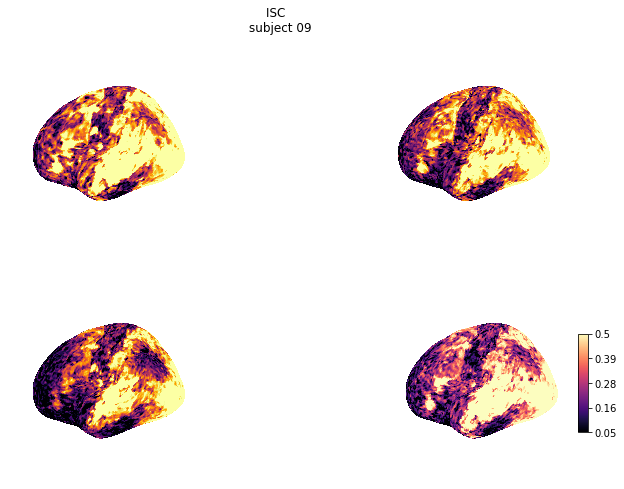

In [49]:
# f, axs = plt.subplots(2, 2)
figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize = (12,8))
plot_surf(fsaverage_inflated_L,isc_sub01_L, 
          title='ISC \n behavior attention task\n left hemi', 
          hemi='left', view = 'lateral', vmin=.05, vmax=.5, cmap = 'inferno',axes=axes[0][0])
plot_surf(fsaverage_inflated_L,isc_sub05_L, 
title='ISC \n behavior attention task\n left hemi', 
hemi='left', view = 'lateral', vmin=.05, vmax=.50, cmap = 'inferno',axes=axes[0][1])
plot_surf(fsaverage_inflated_L,isc_sub06_L, 
title='ISC \n behavior attention task\n left hemi', 
hemi='left', view = 'lateral', vmin=.05, vmax=.50, cmap = 'inferno',axes=axes[1][0])
plot_surf(fsaverage_inflated_L,isc_sub09_L, 
title='ISC \n subject 09', colorbar=True,
hemi='left', view = 'lateral', vmin=.05, vmax=.50, cmap = 'magma',axes=axes[1][1])

plt.show()

# nilearn plot

In [66]:
def double_cmap(cm=plt.cm.inferno, n_colors=100): 
    double_c = np.vstack((cm(np.linspace(0, 1, n_colors)),
                          cm(np.linspace(0, 1, n_colors))))
                          
    return colors.ListedColormap(double_c)

In [68]:
double_inferno = double_cmap(cm=plt.cm.inferno)

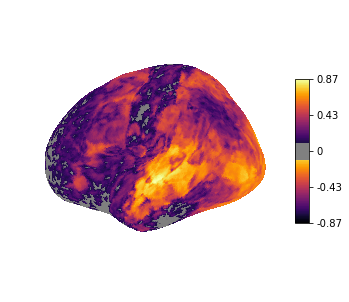

In [71]:
from nilearn import datasets
from nilearn import surface
import nilearn


fsaverage = datasets.fetch_surf_fsaverage()
# texture = surface.vol_to_surf(stat_img, fsaverage.pial_right)

nilearn.plotting.plot_surf_stat_map(fsaverage_inflated_L, group_fisher[np.newaxis,:], cmap = double_inferno, threshold = .1);

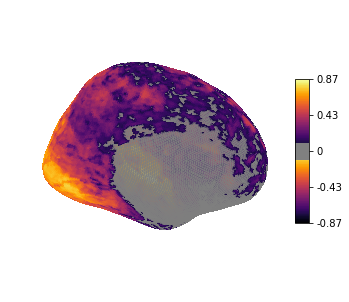

In [72]:
nilearn.plotting.plot_surf_stat_map(fsaverage_inflated_L, group_fisher[np.newaxis,:], 
cmap = double_inferno, threshold = .1,
view = 'medial');

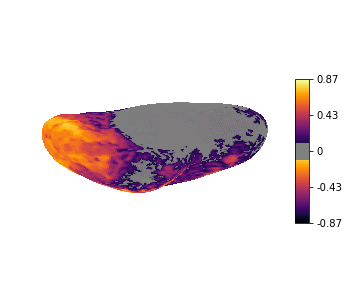

In [73]:
nilearn.plotting.plot_surf_stat_map(fsaverage_inflated_L, group_fisher[np.newaxis,:], 
cmap = double_inferno, threshold = .1,
view = 'ventral');